In [2]:
import pandas as pd
import pickle as pkl
import os


def get_target_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['diagnosis_anns']
            anns = {(k, question): v2 for k, v in anns.items() for question, v2 in v.items()}
            del instance_data['diagnosis_anns']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()

from collections import defaultdict
def get_full_target_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_target_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    return dict(dfs)

In [3]:
dfs = get_full_target_df([
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-7-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-9-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-14-23/target_annotations',])
df = dfs['val2']
df

,instance_idx,split,"(pneumonia, is_confident_diagnosis)","(pneumonia, could_be_identified_earlier)","(cancer, is_confident_diagnosis)","(cancer, could_be_identified_earlier)","(pulmonary edema, is_confident_diagnosis)","(pulmonary edema, could_be_identified_earlier)",annotator,"(pulmonary edema, report_idx)","(pneumonia, report_idx)","(cancer, report_idx)"
0,11,val2,No,NaN,NaN,NaN,NaN,NaN,Andrea_Young,NaN,NaN,NaN
1,12,val2,Yes,Yes,NaN,NaN,NaN,NaN,Andrea_Young,NaN,NaN,NaN
2,16,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
3,17,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
4,22,val2,Yes,Yes,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
5,22,val2,No,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
6,34,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
7,35,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young,NaN,NaN,NaN
8,40,val2,NaN,NaN,NaN,NaN,Yes,No,Andrea_Young,NaN,NaN,NaN
0,49,val2,Yes,Yes,NaN,NaN,Yes,No,Andrea,35,57,NaN


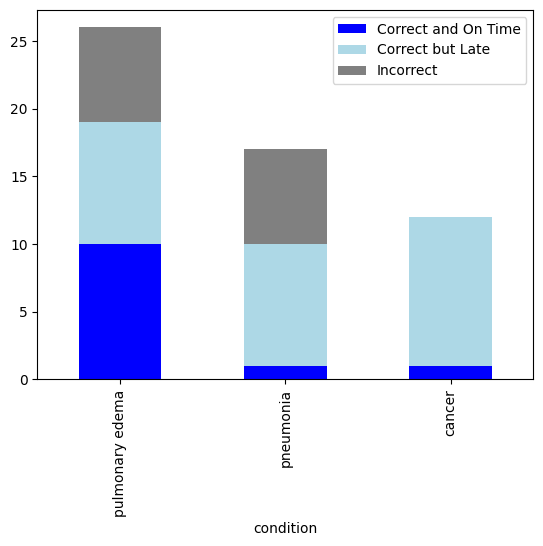

In [4]:
import seaborn as sns
from collections import Counter
rows = []
for condition in ['pulmonary edema', 'pneumonia', 'cancer']:
    y = df[~df[(condition, 'is_confident_diagnosis')].isna()].apply(lambda r:
        'Incorrect' if r[(condition, 'is_confident_diagnosis')] == 'No' else \
        'Correct and On Time' if r[(condition, 'could_be_identified_earlier')] == 'No' else \
        'Correct but Late', axis=1)
    y = Counter(y)
    rows.append({
        'condition': condition,
    })
    rows[-1].update(y)
chart = pd.DataFrame(rows).set_index('condition').plot(kind='bar', stacked=True, color=['blue', 'lightblue', 'grey'])

